In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
train_id = pd.read_csv('creditcard_dataset2.csv/train_identity.csv')
train_trans = pd.read_csv('creditcard_dataset2.csv/train_transaction.csv')

In [2]:
print(train_id.shape)
print(train_trans.shape)

(144233, 41)
(590540, 394)


In [3]:
#Merge Transaction and Identity table
train = train_trans.merge(train_id, how='left', on='TransactionID') 
#Check for missing values
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

In [4]:
del train_id
del train_trans

In [5]:
#Remove high missing value columns
columnsToDelete = []
for col in train.columns:
    if(train[col].isnull().sum()/len(train[col]) >= 0.8):
        print(col, "% NaN:", train[col].isnull().sum()/len(train[col]))
        columnsToDelete.append(col)

dist2 % NaN: 0.9362837403054831
D6 % NaN: 0.8760676668811597
D7 % NaN: 0.9340992989467267
D8 % NaN: 0.8731229044603245
D9 % NaN: 0.8731229044603245
D12 % NaN: 0.8904104717715988
D13 % NaN: 0.8950926270870728
D14 % NaN: 0.8946946862193924
V138 % NaN: 0.8612371727571375
V139 % NaN: 0.8612371727571375
V140 % NaN: 0.8612371727571375
V141 % NaN: 0.8612371727571375
V142 % NaN: 0.8612371727571375
V143 % NaN: 0.8612270125647712
V144 % NaN: 0.8612270125647712
V145 % NaN: 0.8612270125647712
V146 % NaN: 0.8612371727571375
V147 % NaN: 0.8612371727571375
V148 % NaN: 0.8612371727571375
V149 % NaN: 0.8612371727571375
V150 % NaN: 0.8612270125647712
V151 % NaN: 0.8612270125647712
V152 % NaN: 0.8612270125647712
V153 % NaN: 0.8612371727571375
V154 % NaN: 0.8612371727571375
V155 % NaN: 0.8612371727571375
V156 % NaN: 0.8612371727571375
V157 % NaN: 0.8612371727571375
V158 % NaN: 0.8612371727571375
V159 % NaN: 0.8612270125647712
V160 % NaN: 0.8612270125647712
V161 % NaN: 0.8612371727571375
V162 % NaN: 0.8612

In [6]:
train = train.drop(columns=columnsToDelete)

In [7]:
v_columns = []
for col in ['V'+str(x) for x in range(1,340)]:
    if col in train.columns:
        v_columns.append(col)

In [8]:
cat_label_features = ["card1","card2","card3","card5", "addr1", "addr2", "id_13","id_17","id_19","id_20","id_31","DeviceInfo"]
num_features = []
cat_onehot_features = ["ProductCD","card4","card6", "M1","M2","M3","M4","M5","M6","M7","M8","M9","id_12","id_15",
                      "id_16","id_28","id_29","id_35","id_36","id_37","id_38","DeviceType","P_emaildomain",
                       "R_emaildomain"]
for col in train.columns:
    if col not in cat_label_features and col not in v_columns and col not in cat_onehot_features:
        num_features.append(col)
num_features.remove('isFraud')
num_features.remove('TransactionID')

print(len(cat_onehot_features))
print(len(cat_label_features))
print(len(num_features))

24
12
30


In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c] = train[c].map(emails)

In [10]:
train["new_browser"] = np.zeros(train.shape[0])

def setBinaryBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'new_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'new_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'new_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'new_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'new_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'new_browser']=1
    return df

train = setBinaryBrowser(train)
cat_label_features.remove('id_31')
cat_onehot_features.append('new_browser')
train = train.drop(columns='id_31')

In [11]:
def transform_hour(df, col='TransactionDT'):
    hours = df[col] / (3600)        
    hours = np.floor(hours) % 24
    return hours

train['hours'] = transform_hour(train)
num_features.remove('TransactionDT')
cat_onehot_features.append('hours')

In [12]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())  
    ]
)

v_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor_c = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_onehot_features)
    ]
)

preprocessor_v = ColumnTransformer(
    transformers = [
        ('v', v_transformer, v_columns)
    ]
)

preprocessor_num = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features)
    ]
)

In [13]:
for col in cat_label_features:
    train[col] = train[col].fillna(train[col].mode()[0])

le = LabelEncoder()
train[cat_label_features] = train[["card1","card2","card3","card5", "addr1",
                                   "addr2", "id_13","id_17","id_19","id_20","DeviceInfo"]].apply(le.fit_transform)

In [14]:
from sklearn.model_selection import train_test_split
y_train = train.isFraud.values
x_train, x_test, y_train, y_test = train_test_split(train, y_train, stratify = y_train, test_size = 0.25, random_state = 5)

In [15]:
x_train_cat_label = x_train[cat_label_features]
x_test_cat_label = x_test[cat_label_features]
mms = MinMaxScaler()
x_train_cat_label = mms.fit_transform(x_train_cat_label)
x_test_cat_label = mms.transform(x_test_cat_label)
print(x_train_cat_label.shape)

(442905, 11)


In [16]:
preprocessor_c.fit(x_train[cat_onehot_features])
x_train_cat_onehot = preprocessor_c.transform(x_train[cat_onehot_features])
x_test_cat_onehot = preprocessor_c.transform(x_test[cat_onehot_features])

In [17]:
x_train_cat_onehot = x_train_cat_onehot.toarray()
x_test_cat_onehot = x_test_cat_onehot.toarray()
print(x_train_cat_onehot.shape)

(442905, 97)


In [18]:
preprocessor_v.fit(x_train[v_columns])
x_train_v = preprocessor_v.transform(x_train[v_columns])
x_test_v = preprocessor_v.transform(x_test[v_columns])
print(x_train_v.shape)

(442905, 292)


In [19]:
#Dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
x_train_v = pca.fit_transform(x_train_v)
x_test_v = pca.transform(x_test_v)
var_explained = pca.explained_variance_ratio_.sum()
print(x_train_v.shape)

(442905, 85)


In [20]:
preprocessor_num.fit(x_train[num_features])
x_train_num = preprocessor_num.transform(x_train[num_features])
x_test_num = preprocessor_num.transform(x_test[num_features])
print(x_train_num.shape)
print(x_test_num.shape)

(442905, 29)
(147635, 29)


In [21]:
x_train_num = x_train_num.astype('float32')
x_test_num = x_test_num.astype('float32')
x_train = np.concatenate((x_train_num, x_train_cat_label, x_train_v, x_train_cat_onehot), axis = 1)
x_test = np.concatenate((x_test_num, x_test_cat_label, x_test_v, x_test_cat_onehot), axis = 1)
print(x_train.shape)
print(x_test.shape)

(442905, 222)
(147635, 222)


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, matthews_corrcoef


def print_classification_result(true, predict):
    print(f"Accuracy Score: {accuracy_score(true, predict) * 100:.2f}%")
    print(f"Confusion Matrix: \n {confusion_matrix(true, predict)}\n")
    print(f"MCC_Score:{matthews_corrcoef(true, predict)}\n")
    print(f"f1_score: \n {f1_score(true, predict)}\n")
    print(f"recall_score: \n {recall_score(true, predict)}\n")
    print(f"Precision_Score:{precision_score(true, predict)}")

## Artificial Neural Network

In [23]:
ann = tf.keras.models.Sequential()

In [24]:
ann.add(tf.keras.layers.Dense(units = x_train.shape[1] + 1, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = x_train.shape[1]/2, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

In [25]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
loss = ann.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.3)

Epoch 1/10
9689/9689 [==============================] - 7s 741us/step - loss: 0.1069 - accuracy: 0.9718 - val_loss: 0.0990 - val_accuracy: 0.9735
Epoch 2/10
9689/9689 [==============================] - 7s 736us/step - loss: 0.0952 - accuracy: 0.9744 - val_loss: 0.0917 - val_accuracy: 0.9749
Epoch 3/10
9689/9689 [==============================] - 7s 732us/step - loss: 0.0892 - accuracy: 0.9758 - val_loss: 0.0889 - val_accuracy: 0.9755
Epoch 4/10
9689/9689 [==============================] - 7s 739us/step - loss: 0.0841 - accuracy: 0.9769 - val_loss: 0.0855 - val_accuracy: 0.9761
Epoch 5/10
9689/9689 [==============================] - 7s 754us/step - loss: 0.0803 - accuracy: 0.9777 - val_loss: 0.0854 - val_accuracy: 0.9765
Epoch 6/10
9689/9689 [==============================] - 7s 735us/step - loss: 0.0769 - accuracy: 0.9787 - val_loss: 0.0844 - val_accuracy: 0.9766
Epoch 7/10
9689/9689 [==============================] - 7s 748us/step - loss: 0.0735 - accuracy: 0.9795 - val_loss: 0.0849 -

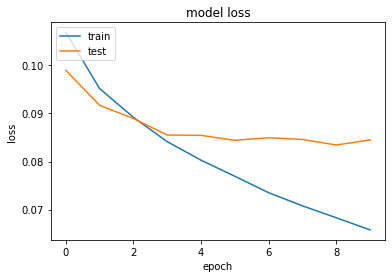

In [27]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_pred = ann.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score: 97.77%
Confusion Matrix: 
 [[142037    432]
 [  2860   2306]]

MCC_Score:0.6038591682754499

f1_score: 
 0.5835020242914979

recall_score: 
 0.44638017808749514

Precision_Score:0.8422205989773557


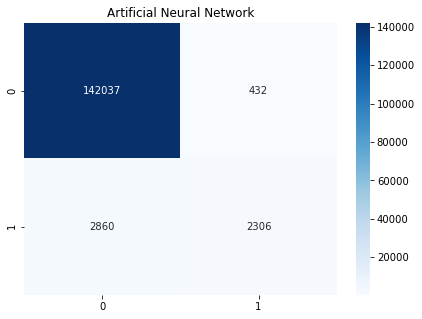

In [29]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
cm.set_title('Artificial Neural Network')
plt.show()

## Parameter Testing

In [44]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = x_train.shape[1] + 1, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = (x_train.shape[1]/2) + 20, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [45]:
loss = ann.fit(x_train, y_train, batch_size = 32, epochs = 11, validation_split = 0.3)

Epoch 1/11
9689/9689 [==============================] - 8s 817us/step - loss: 0.1062 - accuracy: 0.9719 - val_loss: 0.0997 - val_accuracy: 0.9728
Epoch 2/11
9689/9689 [==============================] - 7s 754us/step - loss: 0.0954 - accuracy: 0.9744 - val_loss: 0.0928 - val_accuracy: 0.9750
Epoch 3/11
9689/9689 [==============================] - 7s 743us/step - loss: 0.0894 - accuracy: 0.9757 - val_loss: 0.0901 - val_accuracy: 0.9762
Epoch 4/11
9689/9689 [==============================] - 7s 752us/step - loss: 0.0847 - accuracy: 0.9768 - val_loss: 0.0883 - val_accuracy: 0.9761
Epoch 5/11
9689/9689 [==============================] - 7s 746us/step - loss: 0.0806 - accuracy: 0.9780 - val_loss: 0.0858 - val_accuracy: 0.9767
Epoch 6/11
9689/9689 [==============================] - 7s 752us/step - loss: 0.0768 - accuracy: 0.9786 - val_loss: 0.0849 - val_accuracy: 0.9768
Epoch 7/11
9689/9689 [==============================] - 8s 781us/step - loss: 0.0734 - accuracy: 0.9797 - val_loss: 0.0895 -

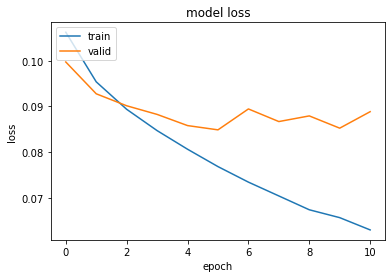

In [46]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [47]:
y_pred = ann.predict(x_test)
y_pred = np.round(y_pred)

In [48]:
print_classification_result(y_test, y_pred)

Accuracy Score: 97.75%
Confusion Matrix: 
 [[141887    582]
 [  2742   2424]]

MCC_Score:0.6051957226985354

f1_score: 
 0.5932452276064611

recall_score: 
 0.4692218350754936

Precision_Score:0.8063872255489022


In [38]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = x_train.shape[1] + 1, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = (x_train.shape[1]/2) - 20, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
loss = ann.fit(x_train, y_train, batch_size = 32, epochs = 11, validation_split = 0.3)

Epoch 1/11
9689/9689 [==============================] - 7s 761us/step - loss: 0.1066 - accuracy: 0.9719 - val_loss: 0.0958 - val_accuracy: 0.9735
Epoch 2/11
9689/9689 [==============================] - 7s 748us/step - loss: 0.0956 - accuracy: 0.9743 - val_loss: 0.0934 - val_accuracy: 0.9746
Epoch 3/11
9689/9689 [==============================] - 7s 747us/step - loss: 0.0891 - accuracy: 0.9758 - val_loss: 0.0891 - val_accuracy: 0.9756
Epoch 4/11
9689/9689 [==============================] - 7s 727us/step - loss: 0.0841 - accuracy: 0.9768 - val_loss: 0.0869 - val_accuracy: 0.9764
Epoch 5/11
9689/9689 [==============================] - 7s 754us/step - loss: 0.0802 - accuracy: 0.9779 - val_loss: 0.0883 - val_accuracy: 0.9765
Epoch 6/11
9689/9689 [==============================] - 7s 741us/step - loss: 0.0766 - accuracy: 0.9789 - val_loss: 0.0877 - val_accuracy: 0.9757
Epoch 7/11
9689/9689 [==============================] - 7s 736us/step - loss: 0.0733 - accuracy: 0.9796 - val_loss: 0.0846 -

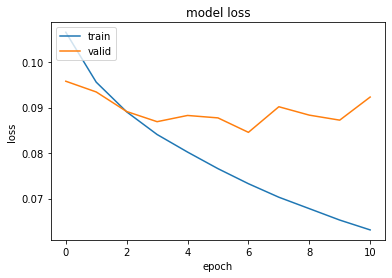

In [40]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [41]:
y_pred = ann.predict(x_test)
y_pred = np.round(y_pred)

In [42]:
print_classification_result(y_test, y_pred)

Accuracy Score: 97.76%
Confusion Matrix: 
 [[141965    504]
 [  2805   2361]]

MCC_Score:0.6040913857543572

f1_score: 
 0.5879716100112066

recall_score: 
 0.4570267131242741

Precision_Score:0.8240837696335078
